## Logistic Regression

CV ROC AUC:   0.6601 ± 0.0047
CV PR  AUC:   0.6406 ± 0.0051
CV Accuracy:  0.6137 ± 0.0032

Hold-out ROC AUC: 0.6501
Hold-out PR  AUC: 0.6316

Classification report (threshold=0.5):
               precision    recall  f1-score   support

           0      0.626     0.625     0.625     12397
           1      0.581     0.581     0.581     11073

    accuracy                          0.604     23470
   macro avg      0.603     0.603     0.603     23470
weighted avg      0.604     0.604     0.604     23470



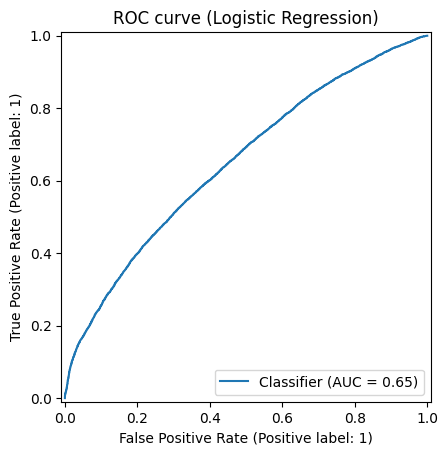

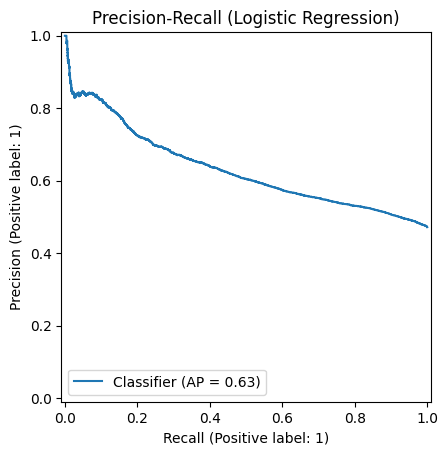


Top positive features:
              feature     coef
age_gender_missing_0 1.005129
      day_2019-11-12 0.555779
  province_xin jiang 0.548474
 province_guang dong 0.494593
      day_2019-11-06 0.457375
   province_jiang xi 0.408134
   province_guang xi 0.404004
           isShare_0 0.381995
   province_ning xia 0.352911
    province_hai wai 0.338055
     province_hu bei 0.320432
      day_2019-11-28 0.303617
 province_xiang gang 0.271744
     province_hu nan 0.255206
       followCnt_log 0.251606

Top negative features:
                 feature      coef
        creator_level_0 -0.210092
     province_liao ning -0.226870
         day_2019-11-30 -0.244679
         day_2019-11-29 -0.256792
        creator_level_2 -0.262452
        province_he bei -0.281759
         day_2019-11-02 -0.318163
     province_shan dong -0.329702
              isShare_1 -0.349789
         day_2019-11-23 -0.373659
         day_2019-11-16 -0.451877
      province_qing hai -0.787218
   age_gender_missing_1 -0.9

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# -------------------------
# Load data
# -------------------------
PATH = Path("../data/cleaned_data.csv")
df = pd.read_csv(PATH)
df.drop(columns="user_level", errors="ignore", inplace=True) 
df.drop(columns="gender", errors="ignore", inplace=True)
# Target
y = df["y_active"].astype(int)

# Columns to drop (IDs/timestamps/high-cardinality identifiers that don’t generalize)
drop_cols = [c for c in [
    "y_active","mlogId","userId","creatorId","contentId","talkId" # date as timestamp; use engineered time features instead
] if c in df.columns]

X = df.drop(columns=drop_cols, errors="ignore")

# -------------------------
# Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# Column typing
# -------------------------
# treat as categorical: pandas object/category/string or small-cardinality integer-like labels
cat_cols = (
    list(X_train.select_dtypes(include=["object","category","string","bool"]).columns)
)

# additionally, mark integer columns with few unique values as categorical (e.g., type, creatorType)
for c in X_train.select_dtypes(include=["int16","int32","int64","Int8","Int16","Int32","Int64","uint8","uint16"]).columns:
    if X_train[c].nunique(dropna=True) <= 20:  # small cardinality → categorical
        if c not in cat_cols:
            cat_cols.append(c)

num_cols = [c for c in X_train.columns if c not in cat_cols]

# -------------------------
# Preprocess
# -------------------------
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
])

cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    n_jobs=None
)

# -------------------------
# Model
# -------------------------
logit = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   # helps if classes are imbalanced
    solver="lbfgs",
    n_jobs=None
)

pipe = Pipeline(steps=[("pre", pre), ("model", logit)])

# -------------------------
# Cross-validation on train
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_validate(
    pipe, X_train, y_train, cv=cv,
    scoring={"roc_auc":"roc_auc", "pr_auc":"average_precision", "acc":"accuracy"},
    n_jobs=None, return_train_score=False
)

print("CV ROC AUC:  ", np.mean(cv_scores["test_roc_auc"]).round(4), "±", np.std(cv_scores["test_roc_auc"]).round(4))
print("CV PR  AUC:  ", np.mean(cv_scores["test_pr_auc"]).round(4), "±", np.std(cv_scores["test_pr_auc"]).round(4))
print("CV Accuracy: ", np.mean(cv_scores["test_acc"]).round(4), "±", np.std(cv_scores["test_acc"]).round(4))

# -------------------------
# Fit on train, evaluate on hold-out
# -------------------------
pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print("\nHold-out ROC AUC:", round(roc_auc_score(y_test, proba), 4))
print("Hold-out PR  AUC:", round(average_precision_score(y_test, proba), 4))

print("\nClassification report (threshold=0.5):\n", classification_report(y_test, pred, digits=3))

# Curves
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC curve (Logistic Regression)"); plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("Precision-Recall (Logistic Regression)"); plt.show()

# -------------------------
# Optional: show top coefficients
# -------------------------
# Build feature names after one-hot
oh = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["oh"]
cat_feature_names = oh.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
feature_names = np.r_[num_cols, cat_feature_names]

coefs = pipe.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)

print("\nTop positive features:\n", coef_df.head(15).to_string(index=False))
print("\nTop negative features:\n", coef_df.tail(15).to_string(index=False))

# -------------------------
# Save model (optional)
# -------------------------
# import joblib
# joblib.dump(pipe, "../data/logreg_pipeline.pkl")
